## Problem 7.13

The initial and boundary conditions stated in the question do not produce the analytical solution stated. Instead we will consider a slightly different system. For the domain $x\in[0, 1]$ and boundary conditions 
\begin{align*}
\partial_x \theta(x=0, \, t) &= H_0 = 0 \\ 
\theta(x=1, \, t) &= \theta_1 = 1 
\end{align*}
let us consider a different initial condition. 
\begin{equation*}
\theta(x, \, t=0) = \theta_0 = 1 + \cos\left(\frac{\pi x}{2}\right) \quad.
\end{equation*}

This system has the analytical solution 
\begin{equation*}
\theta(x, \, t) = 1 + \exp\left(- \left(\frac{\pi}{2}\right)^2 t\right) \cos\left(\frac{\pi x}{2}\right)
\end{equation*}
which we will model instead. Let us first plot this new initial condition

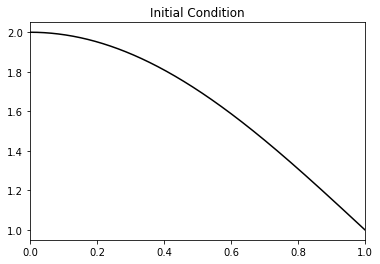

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

# Initial condition 
fig, ax = plt.subplots()
xplt = np.linspace(0, 1, 1000)
ax.plot(xplt, 1 + np.cos(0.5* np.pi * xplt), 'k');
ax.set_title('Initial Condition');
ax.set_xlim([0,1]);

Physically, this system allows for no heat flux at the left boundary, while the RHS boundary must maintain a constant temperature. The domain has no input of heat. To facilitate these conditions, the heat must exit though the right boundary of the system, for which the heat flux is not fixed. Hence, we expect to see a decay in temperature through time until the system is at steady state. 

### Domain setup
Let us define our domain numerically with 10 elements, leading to 11 global nodes. 

In [2]:
L       = 1         # domain size
nelem   = 10        # number of elements, n
npts    = nelem + 1 # n+1

# Global domain node locations
x = np.linspace(0, L, npts)

# Compute Delta x for each element: 
dx = x[1:] - x[:-1]

# Boundary conditions: 
theta_1 = 1
H0      = 0

### K matrix
Next, we compute our global diffusivity matrix based on Eqns. 7.49 - 7.51

In [3]:
# Generate K
K = np.zeros((nelem, nelem))

for ielem in range(nelem):

    if ielem == 0:
        K[ielem, ielem] = 1 / dx[0]
    else:
        K[ielem, ielem] = (1 / dx[ielem - 1]) + (1 / dx[ielem])
        K[ielem - 1, ielem] = -1 / dx[ielem - 1]
        K[ielem, ielem - 1] = -1 / dx[ielem - 1]

### Mass matrix
The mass matrix can be similarly computed based on Eqns 7.88 - 7.90

In [4]:
M = np.zeros((nelem, nelem))

for ielem in range(nelem):
    if ielem == 0: 
        # 7.88
        M[ielem, ielem] = dx[0] / 3
    else:
        # 7.90
        M[ielem, ielem] = (dx[ielem - 1] + dx[ielem]) / 3  
        # 7.89
        M[ielem - 1, ielem] = dx[ielem - 1] / 6
        M[ielem, ielem - 1] = dx[ielem - 1] / 6

### Forcing

The force vector is given in Eqn. 7.87 as 
\begin{equation*}
F_A = \int_0^1 N_A \, h \: \mathrm{d}x + N_A(0) H_0 - \theta_1 \int_0^1 \left( \partial_x N_A \right) \left( \partial_x N_{n+1} \right) \mathrm{d} x  \quad. 
\end{equation*}
For our case, $h=0$ and $H_0 = 0$ such that the force is only 

\begin{align*}
F_A  &=  \theta_1 \int_0^1 \left( \partial_x N_A \right) \left( \partial_x N_{n+1} \right) \mathrm{d} x  \quad, \\ 
     &=  \theta_1 \int_{x_x}^{x_{n+1}} \left( \partial_x N_{n} \right) \left( \partial_x N_{n+1} \right) \mathrm{d} x  \quad,\\ 
      &=  \frac{\theta_1}{\Delta_x}
\end{align*}

at the $n$th node only. 

In [5]:
F = np.zeros(nelem)
F[-1] = theta_1/(dx[-1])

### Timestepping 

Finally, we can step our system of equations in time using the Generalised Trapezoidal Time Scheme discussed in Section 7.3.3. For $\eta = 0.5$ this is a centered finite difference method in time. 

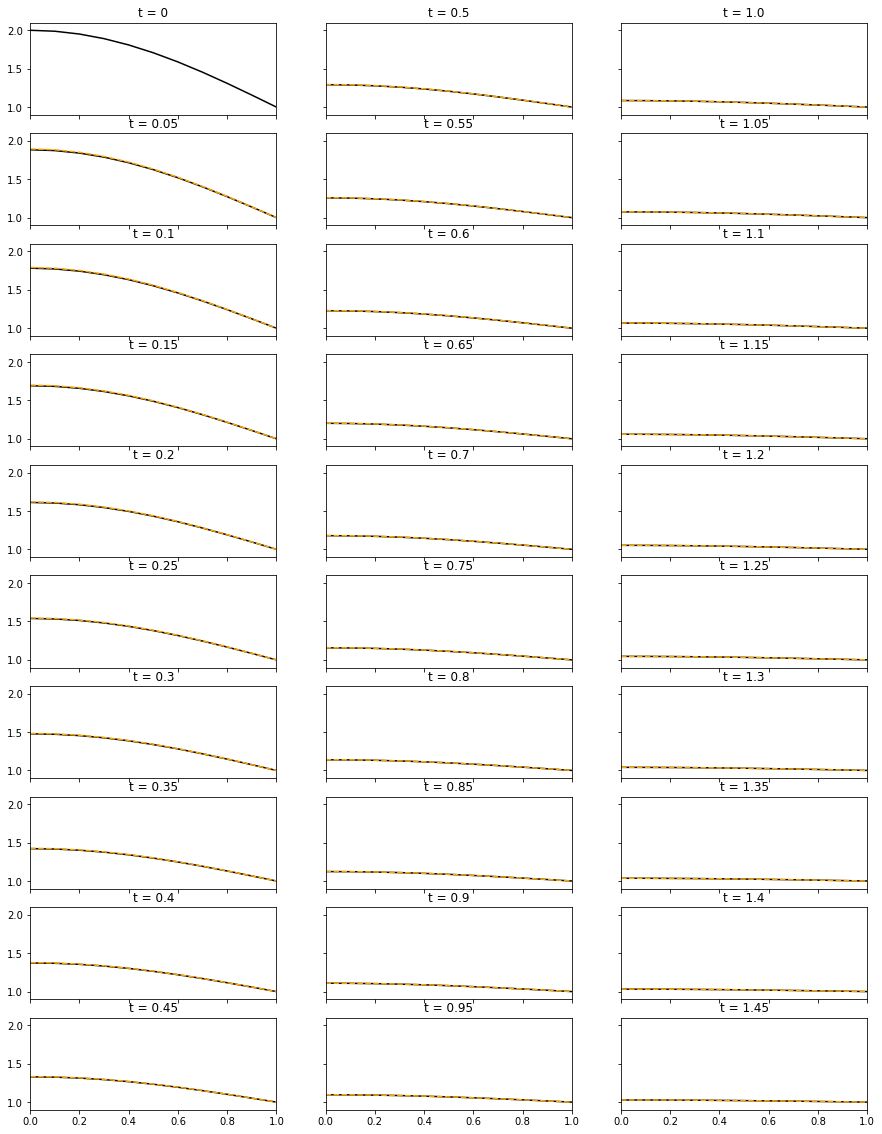

In [12]:
eta    = 0.5    # time-scheme parameter
dt     = 0.01   # timestep
nsteps = 150    # number of timesteps

# Initialise temperature and derivative
temp       = np.zeros(npts)
dtemp_dt   = np.zeros(npts)

# Set initial condition 
temp       = 1 + np.cos(0.5* np.pi * x)

# Inverse of [M + eta \delta t K]
# rearranged version of Eqn 7.92
MKinv = np.linalg.inv(M + eta*dt*K)

# Create plots of time evolution
fig, ax = plt.subplots(10, 3,
                       sharey=True, 
                       figsize=(15,20),
                       sharex=True)

# Step in time 
time = 0

# Plot initial condition 
ax[0,0].set_title(f"t = 0");
ax[0,0].plot(x, temp, 'k')

iax = 1
icol = 0 
for istep in range(1,nsteps):
    # Compute time 
    time += dt

    # --- FEM calculation ---
    # Predictor:
    dtilde = temp[:-1] + (1-eta)* dt * dtemp_dt[:-1]

    # Solve for dtemp_dt at next timestep
    dtemp_dt[:-1] = np.matmul(MKinv, F - np.matmul(K, dtilde))

    # Corrector:
    temp[:-1] = dtilde + (eta * dt * dtemp_dt[:-1])
    
    # Plot every 5 timesteps
    if istep%5 == 0:

        # Compute analytical solution and plot 
        analytical =  1 + (np.exp(- 0.25 * time * np.pi**2 ) *
                           np.cos(0.5*np.pi *x))
        ax[iax, icol].plot(x, analytical, 'k')
        
        # Plot FEM 
        ax[iax, icol].set_title(f"t = {np.around(time,2)}");
        ax[iax, icol].plot(x, temp, 'orange', linestyle='--')
        
        iax += 1
        if iax==10: 
            icol += 1
            iax = 0 
        
# Some plot formatting 
ax[0,0].set_xlim([0,1]);
ax[0,0].set_ylim([0.9,2.1]);